In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install optuna

In [3]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/MUFG2023"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")
OOF_DIR = os.path.join(OUTPUT_DIR, 'oof')
SUB_NUM_DIR = os.path.join(OUTPUT_DIR, 'sub_num')
OUTPUT_EXP21_DIR = DIR + '/output/EXP021/'

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error,  mean_absolute_percentage_error
from sklearn.metrics import f1_score, accuracy_score
import optuna

In [5]:
def get_f1_score(labels, outputs):
    y_pred = outputs
    y_true = labels
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.80, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred>thresh).astype(int))
        #print("Accuracy score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred>best_thresh).astype(int))

In [6]:
class CFG1:
  ver=17
  model="catboost"
  seed=42

class CFG2:
  ver=19
  model="lightgbm"
  seed=42

class CFG3:
  ver=20
  model="xgboost"
  seed=42

class CFG4:
  ver=21
  model="microsoft/deberta-v3-base"
  seed=42

class CFG5:
  ver=41
  model="catboost"
  seed=42

In [7]:
oof_df1 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG1.model}_ver{CFG1.ver}.csv'))
oof_df1.rename(columns={"pred":"pred1"},inplace=True)
oof_df2 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG2.model}_ver{CFG2.ver}.csv'))
oof_df2.rename(columns={"pred":"pred2"},inplace=True)
oof_df3 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG3.model}_ver{CFG3.ver}.csv'))
oof_df3.rename(columns={"pred":"pred3"},inplace=True)
oof_df4 = pd.read_pickle(OUTPUT_EXP21_DIR+'oof_df.pkl')
oof_df4.rename(columns={"pred":"pred4"},inplace=True)
oof_df5 = pd.read_csv(os.path.join(OOF_DIR, f'oof_{CFG5.model}_ver{CFG5.ver}.csv'))
oof_df5.rename(columns={"pred":"pred5"},inplace=True)

In [8]:
oof_df = oof_df1.merge(oof_df2[["index","pred2"]], how="left", on="index").merge(oof_df3[["index","pred3"]], how="left", on="index").merge(oof_df4[["index","pred4"]], how="left", on="index").merge(oof_df5[["index","pred5"]], how="left", on="index")

oof_df["model1"] = oof_df["pred1"].values
oof_df["model2"] = oof_df["pred2"].values
oof_df["model3"] = oof_df["pred3"].values
oof_df["model4"] = oof_df["pred4"].values
oof_df["model5"] = oof_df["pred5"].values

In [9]:
preds_df = oof_df[["is_fraud?","model1","model2","model3","model4","model5"]].copy()
display(preds_df.corr())
print(preds_df.shape)
preds_df.dropna(axis=0,inplace=True)
print(preds_df.shape)
y_true = preds_df["is_fraud?"].values
preds_df.drop("is_fraud?",axis=1,inplace=True)

,is_fraud?,model1,model2,model3,model4,model5
is_fraud?,1.000000,0.705449,0.706214,0.686727,0.574390,0.572585
model1,0.705449,1.000000,0.955161,0.950477,0.795545,0.795389
model2,0.706214,0.955161,1.000000,0.948713,0.785123,0.780226
model3,0.686727,0.950477,0.948713,1.000000,0.815857,0.790588
model4,0.574390,0.795545,0.785123,0.815857,1.000000,0.703650
model5,0.572585,0.795389,0.780226,0.790588,0.703650,1.000000


(471283, 6)
(471283, 6)


In [10]:
for i in range(5):
  score = get_f1_score(y_true, preds_df[f"model{i+1}"])
  print(f"model{i} : {score}")

model0 : 0.6689264376080666
model1 : 0.6709376042709377
model2 : 0.6451733514615908
model3 : 0.5356618952764782
model4 : 0.6546645856191373


In [11]:
SEED = 42
np.random.seed(SEED)

n_models = preds_df.shape[1]
max_iter = 150

In [12]:
def calc_f1_score(weight = np.ones(n_models)):
    y_pred_blended = np.average(preds_df, axis = 1, weights = weight)
    best_score = 0
    best_thresh = 0.5
    for thresh in np.arange(0.1, 0.801, 0.01):
        thresh = np.round(thresh, 2)
        score = f1_score(y_true, (y_pred_blended>thresh).astype(int))
        # print("F1 score at threshold {0} is {1}".format(thresh, score))
        if score > best_score:
          best_score = score
          best_thresh = thresh
    return f1_score(y_true, (y_pred_blended>best_thresh).astype(int))

In [13]:
class Objective:
    def __init__(self, n_models):
        self.n_models = n_models

    def __call__(self, trial):
        weight = [trial.suggest_uniform('weight' + str(n), 0, 1) for n in range(self.n_models)]
        return calc_f1_score(weight)
objective = Objective(n_models)

sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(sampler = sampler,direction='maximize')
study.optimize(objective, n_trials = max_iter, n_jobs = -1)

[I 2023-08-31 09:17:31,128] A new study created in memory with name: no-name-c73b4501-3c3b-4118-89a4-95770d5114f0
<ipython-input-13-97f94d2f71c2>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight = [trial.suggest_uniform('weight' + str(n), 0, 1) for n in range(self.n_models)]
[I 2023-08-31 09:18:04,554] Trial 0 finished with value: 0.6349966162124688 and parameters: {'weight0': 0.24339268150585236, 'weight1': 0.02271767801676916, 'weight2': 0.2216980252837758, 'weight3': 0.8258197108604314, 'weight4': 0.13288145827203435}. Best is trial 0 with value: 0.6349966162124688.
<ipython-input-13-97f94d2f71c2>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  weight = [trial.suggest_uniform('weight' + str(n),

In [14]:
best_weight = list(study.best_params.values())
best_weight = np.array(best_weight) / np.sum(best_weight)
best_score = study.best_value
print('best score: {0}\nbest weight: {1}'.format(best_score, best_weight))

best score: 0.6793020354451147
best weight: [0.27749124 0.51251864 0.00617114 0.01509851 0.18872047]


In [15]:
oof_pred = preds_df["model1"]*best_weight[0] + preds_df["model2"]*best_weight[1] + preds_df["model3"]*best_weight[2] + preds_df["model4"]*best_weight[3] + preds_df["model5"]*best_weight[4]

In [16]:
best_score = 0
best_thresh = 0.5
for thresh in np.arange(0.15, 0.801, 0.01):
    thresh = np.round(thresh, 2)
    score = f1_score(y_true, (oof_pred>thresh).astype(int))
    print("F1 score at threshold {0} is {1}".format(thresh, score))
    if score > best_score:
      best_score = score
      best_thresh = thresh
print()
print("best F1 score at threshold {0} is {1}".format(best_thresh, f1_score(y_true, (oof_pred>best_thresh).astype(int))))

F1 score at threshold 0.15 is 0.5062910726683088
F1 score at threshold 0.16 is 0.5236757704336741
F1 score at threshold 0.17 is 0.5393723296984313
F1 score at threshold 0.18 is 0.5548820090928772
F1 score at threshold 0.19 is 0.5689835483036648
F1 score at threshold 0.2 is 0.5820885087739741
F1 score at threshold 0.21 is 0.5934182080230603
F1 score at threshold 0.22 is 0.6046557652821415
F1 score at threshold 0.23 is 0.6141385886840433
F1 score at threshold 0.24 is 0.6231702544031311
F1 score at threshold 0.25 is 0.6314791065512451
F1 score at threshold 0.26 is 0.6387890875807708
F1 score at threshold 0.27 is 0.645020920502092
F1 score at threshold 0.28 is 0.6503566050066774
F1 score at threshold 0.29 is 0.6549530007230658
F1 score at threshold 0.3 is 0.6590337894442893
F1 score at threshold 0.31 is 0.6629020451455803
F1 score at threshold 0.32 is 0.6662621727391319
F1 score at threshold 0.33 is 0.6689727269932048
F1 score at threshold 0.34 is 0.6710288527450614
F1 score at threshold 0

In [17]:
class CFG:
  ver=46
  model="blending"

In [18]:
test_pred1 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG1.model}_ver{CFG1.ver}.csv'),header=None)[1]
test_pred2 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG2.model}_ver{CFG2.ver}.csv'),header=None)[1]
test_pred3 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG3.model}_ver{CFG3.ver}.csv'),header=None)[1]
test_pred4 = pd.read_csv(os.path.join(SUB_NUM_DIR, f"submit_num_microsoft-deberta-v3-base_seed42_ver21.csv"), header=None)[1]
test_pred5 = pd.read_csv(os.path.join(SUB_NUM_DIR, f'submit_num_{CFG5.model}_ver{CFG5.ver}.csv'))["pred"]

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0


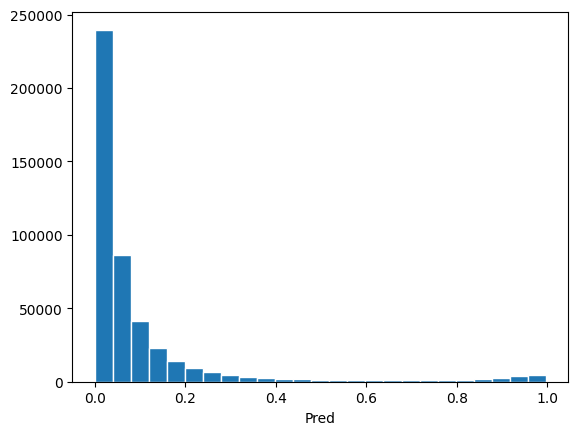

,0,1
0,471283,0
1,471284,0
2,471285,0
3,471286,1
4,471287,0
...,...,...
457953,929236,0
457954,929237,0
457955,929238,0
457956,929239,0


In [19]:
submit = pd.read_csv(os.path.join(INPUT_DIR,"sample_submit.csv"), header=None)
pred = test_pred1*best_weight[0] + test_pred2*best_weight[1] + test_pred3*best_weight[2]  + test_pred4*best_weight[3]  + test_pred5*best_weight[4]
submit[1] = (pred>best_thresh).astype(int)

submit.to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_ver{CFG.ver}.csv'), index=False, header=None)
display(submit.head())

plt.hist(pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(submit)

In [20]:
pred

0         0.051742
1         0.176099
2         0.067733
3         0.740512
4         0.018977
            ...   
457953    0.042809
457954    0.027624
457955    0.022854
457956    0.158390
457957    0.023778
Length: 457958, dtype: float64